In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Activation
from tensorflow.keras.layers import UpSampling2D, add, ZeroPadding2D, PReLU, Cropping2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import keras.backend as K

import os
import sys
import datetime
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

#devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')


## Hyperparameters

In [2]:
height_lr = 68
width_lr = 90
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"
filename = "srgan-4"
use_saved_gen = False

batch_size = 16
epochs = 10_000

gen_lr = 1e-4 #1e-4
dis_lr = 1e-4 #1e-4
loss_weights=[1e-3, 0.006] #1e-3, 0.006
gan_loss = 'mse'
dis_loss = 'binary_crossentropy'

residual_blocks=16 #16
filters=64 #64

workers = 6
max_queue = 12

## Helper Functions

In [3]:
def PSNR(y_true, y_pred):
    return -10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)

def preprocess_vgg(x):
    if isinstance(x, np.ndarray):
        return preprocess_input((x+1)*127.5)
    else:            
        return Lambda(lambda x: preprocess_input(tf.add(x, 1) * 127.5))(x)

def SubpixelConv2D(name, scale=2):

    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                None if input_shape[1] is None else input_shape[1] * scale,
                None if input_shape[2] is None else input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name=name)

## Data

In [4]:
class DataLoader(Sequence):
    def __init__(self, list_IDs, batch_size=4):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.on_epoch_end()

    @staticmethod
    def scale_lr_imgs(imgs):
        """Scale low-res images prior to passing to SRGAN"""
        return imgs / 255.
    
    @staticmethod
    def unscale_lr_imgs(imgs):
        """Un-Scale low-res images"""
        return imgs * 255
    
    @staticmethod
    def scale_hr_imgs(imgs):
        """Scale high-res images prior to passing to SRGAN"""
        return imgs / 127.5 - 1
    
    @staticmethod
    def unscale_hr_imgs(imgs):
        """Un-Scale high-res images"""
        return (imgs + 1.) * 127.5
    
    @staticmethod
    def load_img(path):
        img = Image.open(path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img)
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        imgs_hr = []
        imgs_lr = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_hr = self.load_img(filepath)
                image_hr = 255 * resize(image_hr, (shape_hr[0], shape_hr[1]))
                filepath = os.path.join(data_dir+'quarter', filename)
                image_lr = self.load_img(filepath)
                image_lr = 255 * resize(image_lr, (shape_lr[0], shape_lr[1]))
                if len(image_hr.shape) > 2 and len(image_lr.shape) > 2:
                    #Y.append(resize(image_y, (self.dim[0], self.dim[1]+8)))
                    image_hr = self.scale_hr_imgs(image_hr)
                    image_lr = self.scale_lr_imgs(image_lr)
                    imgs_hr.append(image_hr)
                    imgs_lr.append(image_lr)
                    
        imgs_hr = np.array(imgs_hr)
        imgs_lr = np.array(imgs_lr)
        #print(f'Length of X: {len(X)}')
        return imgs_lr, imgs_hr   

## Models

### VGG

In [5]:
img_vgg = Input(shape=shape_hr)
vgg = VGG19(weights="imagenet", include_top=False, input_tensor=img_vgg)
vgg.summary()
vgg = Model(inputs=img_vgg, outputs=vgg.layers[20].output)
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Generator

In [6]:
def residual_block(input):
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input)
    x = BatchNormalization(momentum=0.8)(x)
    x = PReLU(shared_axes=[1,2])(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = add([x, input])
    return x

def upsample(x, number):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='upSampleConv2D_'+str(number))(x)
    x = SubpixelConv2D('upSampleSubPixel_'+str(number), 2)(x)
    x = PReLU(shared_axes=[1,2], name='upSamplePReLU_'+str(number))(x)
    return x

lr_input = Input(shape=(None, None, 3))
x_start = Conv2D(64, kernel_size=9, strides=1, padding='same')(lr_input)
x_start = PReLU(shared_axes=[1,2])(x_start)

r = residual_block(x_start)
for _ in range(residual_blocks - 1):
    r = residual_block(r)

x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
x = BatchNormalization(momentum=0.8)(x)
x = add([x, x_start])

x = upsample(x, 1)
x = upsample(x, 2)

hr_output = Conv2D(
    channels, 
    kernel_size=9, 
    strides=1, 
    padding='same', 
    activation='tanh'
)(x)

generator = Model(inputs=lr_input, outputs=hr_output)   
#generator.summary()

### Discriminator

In [7]:
def conv2d_block(input, filters, strides=1, bn=True):
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    return d

img_dis = Input(shape=shape_hr)
x = conv2d_block(img_dis, filters, bn=False)
x = conv2d_block(x, filters, strides=2)
x = conv2d_block(x, filters*2)
x = conv2d_block(x, filters*2, strides=2)
x = conv2d_block(x, filters*4)
x = conv2d_block(x, filters*4, strides=2)
x = conv2d_block(x, filters*8)
x = conv2d_block(x, filters*8, strides=2)
x = Dense(filters*16)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=img_dis, outputs=x)
#discriminator.summary()

### Compile: VGG, Generator, Discriminator

In [8]:
vgg.compile(
            loss='mse',
            optimizer=Adam(0.0001, 0.9),
            metrics=['accuracy']
        )

generator.compile(
            loss=gan_loss,
            optimizer=Adam(gen_lr, 0.9),
            metrics=['mse', PSNR]
        )

discriminator.compile(
            loss=dis_loss,
            optimizer=Adam(dis_lr, 0.9),
            metrics=['accuracy']
        )

### SRGAN

In [9]:
img_lr = Input(shape_lr)
generated_hr = generator(img_lr)
generated_features = vgg(
    preprocess_vgg(generated_hr)
)
discriminator.trainable = False
generated_check = discriminator(generated_hr)
generated_features = Lambda(lambda x: x, name='Content')(generated_features)
generated_check = Lambda(lambda x: x, name='Adversarial')(generated_check)

srgan = Model(inputs=img_lr, outputs=[generated_check, generated_features]) 
srgan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             1554883     input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           model_1[1][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    5219137     model_1[1][0]                    
____________________________________________________________________________________________

### Compile: SRGAN

In [10]:
srgan.compile(
            loss=[dis_loss, gan_loss],
            loss_weights=loss_weights,
            optimizer=Adam(gen_lr, 0.9)
        )

## Training

### Training Generator

In [11]:
if use_saved_gen:
    generator.load_weights(f"saved_models/{filename}")
else:
    files = os.listdir(data_dir+'full')
    gen_loader = DataLoader(files, batch_size=batch_size)
    generator.fit_generator(
                gen_loader,
                steps_per_epoch=1000,
                epochs=epochs//400,
                use_multiprocessing=True,
                workers=workers
            )
    generator.save_weights(f"saved_models/{filename}")

### Training SRGAN

In [12]:
#Print/Save Variables:
print_frequency = 25

loader = DataLoader(os.listdir(data_dir+'full'), batch_size=batch_size)
enqueuer = OrderedEnqueuer(loader, use_multiprocessing=True, shuffle=True)
enqueuer.start(workers=workers, max_queue_size=max_queue)
output_generator = enqueuer.get()

disciminator_output_shape = list(discriminator.output_shape)
disciminator_output_shape[0] = batch_size
disciminator_output_shape = tuple(disciminator_output_shape)

real = np.ones(disciminator_output_shape)
fake = np.zeros(disciminator_output_shape)

print_losses = {"G": [], "D": []}
history = {"G": [], "D": [], "acc": []}
start_epoch = datetime.datetime.now()

idxs = np.random.randint(0, len(loader), epochs) 
print(idxs)

for epoch in range(0, epochs):
    if (epoch-1) % (print_frequency) == 0:
        start_epoch = datetime.datetime.now()

    imgs_lr, imgs_hr = next(output_generator)
    generated_hr = generator.predict(imgs_lr)

    real_loss = discriminator.train_on_batch(imgs_hr, real)
    fake_loss = discriminator.train_on_batch(generated_hr, fake)
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    features_hr = vgg.predict(preprocess_vgg(imgs_hr))
    generator_loss = srgan.train_on_batch(imgs_lr, [real, features_hr])      

    print_losses['G'].append(generator_loss)
    print_losses['D'].append(discriminator_loss)

    if epoch % print_frequency == 0:
        g_avg_loss = np.array(print_losses['G']).mean(axis=0)
        d_avg_loss = np.array(print_losses['D']).mean(axis=0)
        print("\nEpoch {}/{} | Time: {}s\n>> Generator/GAN: {}\n>> Discriminator: {}".format(
            epoch, epochs,
            (datetime.datetime.now() - start_epoch).seconds,
            ", ".join(["{}={:.4f}".format(k, v) for k, v in zip(srgan.metrics_names, g_avg_loss)]),
            ", ".join(["{}={:.4f}".format(k, v) for k, v in zip(discriminator.metrics_names, d_avg_loss)])
        ))
        sys.stdout.flush()
        history["G"].append(g_avg_loss[0])
        history["D"].append(d_avg_loss[0])
        history["acc"].append(d_avg_loss[1])
        print_losses = {"G": [], "D": []}

[ 9601  1889 10010 ...  5812  7413  7346]

Epoch 0/10000 | Time: 12s
>> Generator/GAN: loss=0.0276, Adversarial_loss=0.7322, Content_loss=4.4787
>> Discriminator: loss=1.0202, accuracy=0.3483

Epoch 25/10000 | Time: 26s
>> Generator/GAN: loss=0.0298, Adversarial_loss=0.6883, Content_loss=4.8501
>> Discriminator: loss=0.7224, accuracy=0.4899

Epoch 50/10000 | Time: 25s
>> Generator/GAN: loss=0.0277, Adversarial_loss=0.7674, Content_loss=4.4943
>> Discriminator: loss=0.6748, accuracy=0.5788

Epoch 75/10000 | Time: 26s
>> Generator/GAN: loss=0.0271, Adversarial_loss=0.8422, Content_loss=4.3826
>> Discriminator: loss=0.5896, accuracy=0.6924

Epoch 100/10000 | Time: 26s
>> Generator/GAN: loss=0.0266, Adversarial_loss=0.9205, Content_loss=4.2812
>> Discriminator: loss=0.4985, accuracy=0.7638

Epoch 125/10000 | Time: 26s
>> Generator/GAN: loss=0.0260, Adversarial_loss=0.9947, Content_loss=4.1705
>> Discriminator: loss=0.3207, accuracy=0.8879

Epoch 150/10000 | Time: 26s
>> Generator/GAN: loss

KeyboardInterrupt: 

## Results

(256, 256, 3)


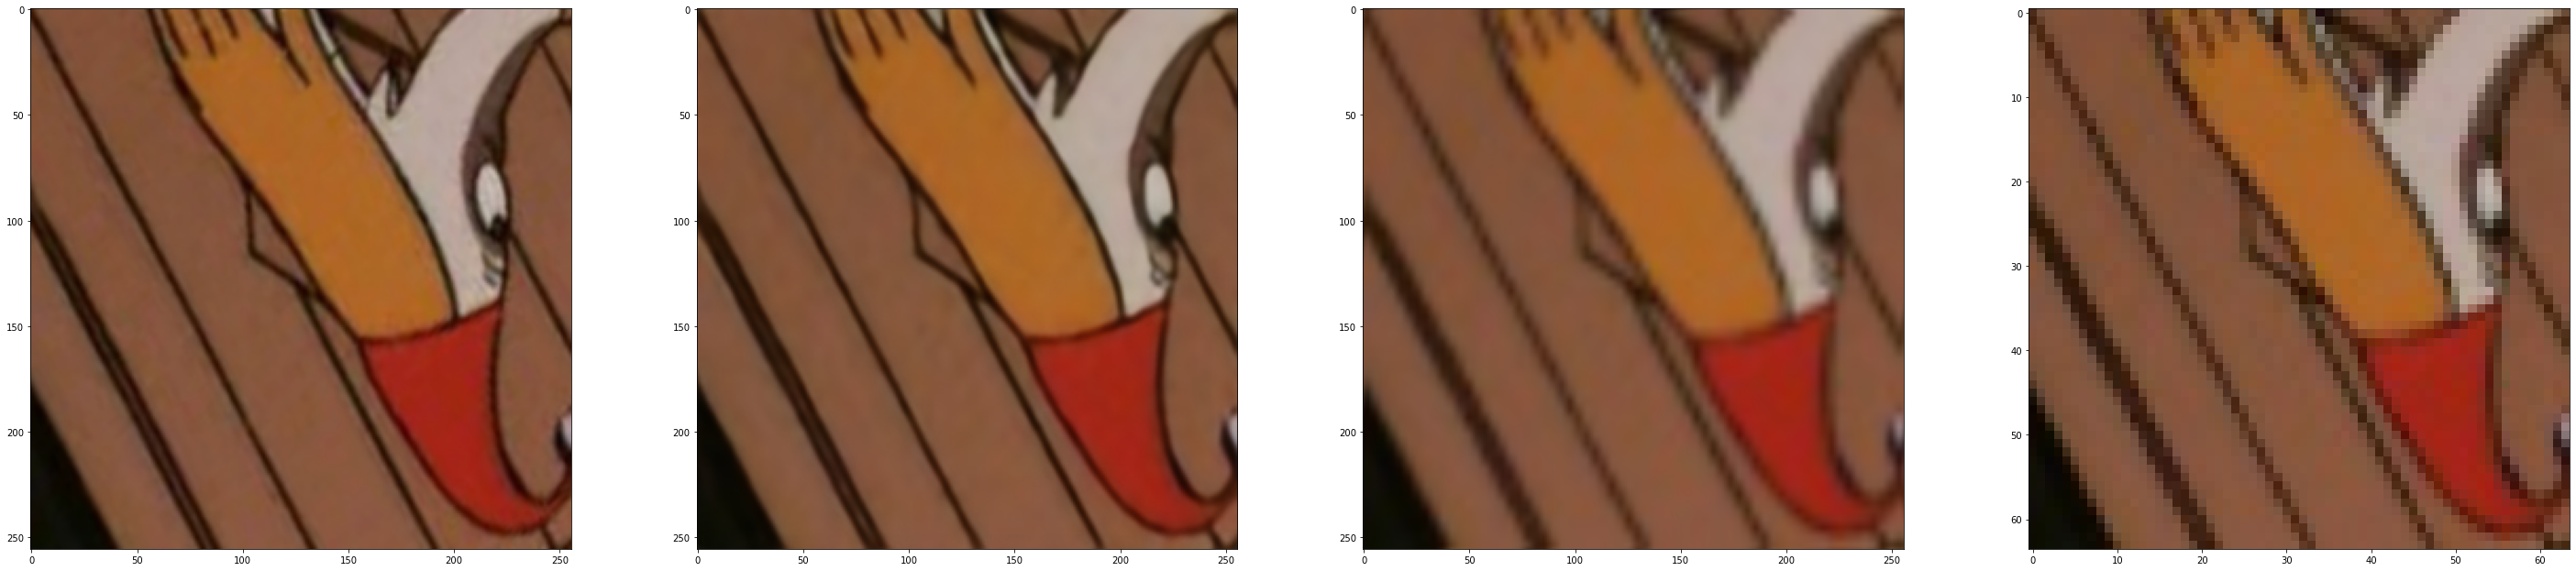

In [14]:
random_names = os.listdir(data_dir+'full')
image_name = random_names[random.randint(0, len(random_names))]
#full_image = pyplot.imread(os.path.join(data_dir+'full', image_name))
full_image = DataLoader.load_img(os.path.join(data_dir+'full', image_name))
full_image = resize(full_image, (shape_hr[0], shape_hr[1]))
print(full_image.shape)
#quarter_image = pyplot.imread(os.path.join(data_dir+'quarter', image_name))
quarter_image = DataLoader.load_img(os.path.join(data_dir+'quarter', image_name))
quarter_image = resize(quarter_image, (shape_lr[0], shape_lr[1]))
#print(quarter_image[:3,:3,:])
pred_image = DataLoader.scale_lr_imgs(255 * quarter_image)
#print(pred_image[:3,:3,:])
pred_image = np.expand_dims(pred_image, 0)
pred_image = generator.predict(pred_image)[0]
#print(pred_image[:3,:3,:])
pred_image = DataLoader.unscale_hr_imgs(pred_image)
#print(pred_image[:3,:3,:])
pred_image = np.array(pred_image).astype(np.uint8)
#print(pred_image[:3,:3,:])
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(full_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quarter_image, (shape_hr[0], shape_hr[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quarter_image)

In [ ]:
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '2.jpg'))
full_size = full_image.shape
print(full_size)
quater_images = np.empty((16, full_size[0]//8, full_size[1]//8, 3), dtype=float)
quater_images_og = np.empty((16, full_size[0]//4, full_size[1]//4, 3), dtype=float)
quater_images_scaled = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*2, full_size[1]*2, 3), dtype=float)
quater_image_4x = np.empty((full_size[0]//2, full_size[1]//2, 3), dtype=float)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0])
        x_e = int(((i+1)/4.)*full_size[0])
        y_s = int((j/4.)*full_size[1])
        y_e = int(((j+1)/4.)*full_size[1])
        quater_images[k] = resize(full_image[x_s:x_e, y_s:y_e],
            (full_size[0]//8, full_size[1]//8))
        quater_images_og[k] = (1./255) * full_image[x_s:x_e, y_s:y_e]
        k += 1
print(quater_images.shape)

for i in range(0, 16):
    temp = np.expand_dims(quater_images[i], 0)
    temp = autoencoder.predict(temp)
    quater_images_scaled[i] = temp[:]
print(quater_images_scaled.shape)
print(scaled_image.shape)

k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0]*2)
        x_e = int(((i+1)/4.)*full_size[0]*2)
        y_s = int((j/4.)*full_size[1]*2)
        y_e = int(((j+1)/4.)*full_size[1]*2)
        scaled_image[x_s:x_e, y_s:y_e] = quater_images_scaled[k]
        k += 1

seqment = 6
quater_image_4x = autoencoder.predict(np.expand_dims(resize(quater_images_scaled[seqment], (full_size[0]//8, full_size[1]//8)), 0))

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(resize(full_image, (2*full_size[0], 2*full_size[1])))
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quater_images_og[seqment], (2*quater_images_og.shape[1], 2*quater_images_og.shape[2])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quater_images_scaled[seqment])
ax = plt.subplot(10, 10, 5)
plt.imshow(quater_image_4x[0])